In [73]:
!pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


Import relevant libraries

In [74]:
import numpy as np
import matplotlib.pyplot as plt

In [75]:
def assign_binary_label(x1,x2):
    #function y larger than 3x + 2
    if x2 > (0.6*x1 + 0.2):
        label = 0
    else:
        label = 1
    return label

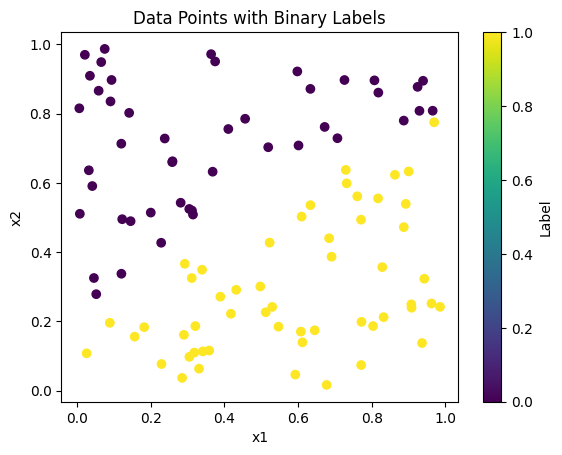

In [76]:
np.random.seed(42)  # For reproducibility

# Create the dataset
num_data_pts = 100
X = np.random.rand(num_data_pts, 2)
y = np.array([assign_binary_label(x1, x2) for x1, x2 in X])

# Plot the data (using the original shape of X)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Points with Binary Labels')
plt.colorbar(label='Label')
plt.show()

Initialize parameters - number of neurons in all layers and initialise weights and biases

In [77]:
input_size = 2
hidden_layer_size = 3
output_size = 1

#this is a fully connected network so each node has a connection all other nodes

# Initialize weights and biases
np.random.seed(42)  # For reproducibility
weights = {
    "W1": np.random.rand(hidden_layer_size, input_size),
    "W2": np.random.rand(output_size, hidden_layer_size)
}
biases = {
    "b1": np.zeros((hidden_layer_size, 1)),
    "b2": np.zeros((output_size, 1))
}

Define activation functions to introduce non-linearity into the network
- Let´s use ReLU in the hidden layers for better performance and faster convergence
- Let´s use the sigmoid function in the output layer as it is a binary classification problem

Let´s start by implementing the sigmoid function - this is a function that maps any input value to a value between 0 and 1. It is commonly used in the output of binary classification problems. 

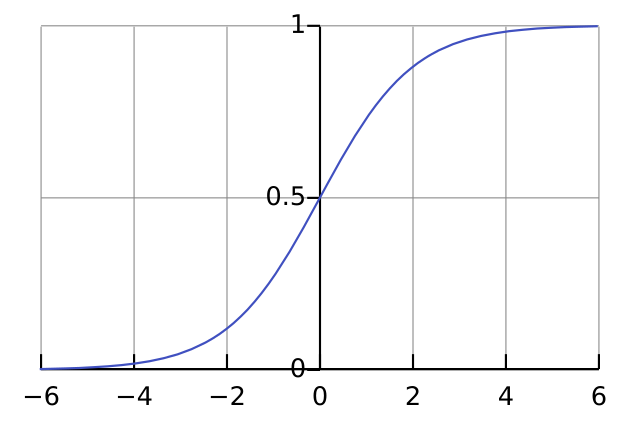

In [78]:
import math

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

We now implement a function to calculate the derivative of the sigmoid function - as it is used in backpropagation. We use the derivative function to help in calculating the gradient of the loss with respect to the weights. 

In [79]:
def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

The ReLU (Rectified Linear Unit) function is an activation function that output the original input if it is positive, and 0 otherwise. 
The output of the ReLU ranges from 0 to infinity. It is commonly used in the hidden layers of neural networks as it helps mitigate the vanishing gradient problem and allows for faster training. 

In [80]:
def relu(x):
    return max(x,0)

To calculate the derivative of the ReLU we need to take two cases into account - first if x is positive and second if it is negative. 

In [81]:
def relu_derivative(x):
    if x > 0: #in this region relu(x) = x
        return 1
    else: #in this region relu(x) = 0
        return 0

Now let´s write some code to pass the data through the network from the input layer to the output layer - this is called the forward pass

In [82]:
def forward_pass(x, weights, biases):
    z1 = np.dot(weights["W1"], x) + biases["b1"]
    a1 = sigmoid(z1)
    z2 = np.dot(weights["W2"], a1) + biases["b2"]
    a2 = sigmoid(z2)
    return z1, a1, z2, a2

We now move on to implementing a loss function. A loss function can tell us how well our network is computing the labels compared to the actual labels. This is a supervised classification problem as we already have the labels so at the end of the forward pass we can see how well our network did in predicting the actual labels. 

For binary classification we often use binary cross-entropy loss

The binary cross-entropy loss for a single sample is given by:
L(actual, predicted) = actual*log(predicted) - (1-actual) * log(1-predicted)

For the whole dataset we compute the average loss based on how the network predicted each single point

In [83]:
def binary_cross_entropy_loss(y_true, y_predicted):
    return y_true*math.log(y_predicted) - (1-y_true) * math.log(1-y_predicted)

So we now have an estimate for how well or bad the network did in predicting the true output for each point. Let´s say it did quite poorly and we want to improve the performance. What we mean by the network doing "poorly" is that the weights and biases were poorly configured to this particular dataset or problem and we need to tune them a bit so that the prediction error decreases. We do this through a process called backpropagation. This is where we figure out how to take the error or the loss and tune the weights and biases by going backwards from the output layer to the input layer. We "propagate" the error backwards. 

For each layer we calculate how much each weight and each bias contributed to the error. These contributions are called gradients. Finally we adjust the weights and biases in the opposite direction of the gradients in order to reduce the error. We start by calculating the gradients for the output layer. 

To calculate the gradients for the output layer we first calculate the error between the prediction and the actual value. 

In [84]:
#this is also called the cost of a single training example 
def output_layer_error(actual, predicted):
    return predicted - actual

We now move on to analyzing the weights in the hidden layer just before the output layer. Remember that we needed to know how each weight an each bias contributed to the error. This is what the gradient can tell us. The gradient can tell us how much a small change in each weight will affect the error.

Let´s try to paint a more visual picture of how the gradient works. Imagine that you´re standing on a mountain and you want to reach the lowest point in the valley as quickly as possible. Ideally you would want to find the steepest slope and go in that direction. The gradient tells us the slope if we take a small step in some direction. If we think of this in terms of loss we can imagine that each point on the mountain is possible values that the loss function can take and the gradient can tell us the gradient in which direction we should go, which also tells us how to change each weight and bias, to reduce the loss. 

But how can calculating the gradient in terms of the loss function tell us how we should tweak our weights and biases? The key mathematical concept used in backpropagation is the chain rule of calculus. The chain rule allows us to compue the derivative of a composition of functions. The loss function is a function of a network´s output, which is a function of the weights and biases. 

In [97]:
def backward_pass(x,y, weights, biases, z1, a1, z2, a2):
    #num examples - will be used to average all the gradients in the batch, helps prevent getting stuck in a local minimum
    n = len(y)
    #this error will be propagated backwards to adjust the weights and biases
    output_error = a2 - y
    #we need to understand how each weight in W2 (between the hidden layer and the output layer) contributed to the error
    #we thus multiply the output error by the activations a1 from the hidden layer to know how much each weight should change to reduce the error
    #we also average over all examples, to get a general direction in which to go, one that isn´t overly influenced by one single extreme example
    dW2 = (1 / n) * np.dot(output_error, a1.T)
    #we then calculate the gradient of the output error wrt the biases in the output layer
    #as biases are added directly to the neurons, the gradient is simply the sum of the "output_error" across all examples averaged by n
    db2 = (1 / n) * np.sum(output_error, axis=1, keepdims=True)
    #we now see how much each neuron in the hidden layer contributed to the error
    #we multiply the W2 weights with the output error
    #we then multiply with the derivative of the activation function (sigmoid e.g.) to account for the non-linearity that it introduced
    dz1 = np.dot(weights["W2"].T, output_error) * sigmoid_derivative(z1)
    #we now see how much each weight in W1 (between the input layer and the hidden layer) should change to reduce the error
    #we do this by multiplying the propagated error dz1 by x and averaging
    #this shows the contribution of each input feature to the error in the hidden layer 
    dW1 = (1 / n) * np.dot(dz1, x.T)
    #lastly we calculate the gradient wrt the biases in the hidden layer
    #again, as biases are added directly to the neurons we sum dz1 across all samples and average
    #this tells us how much each bias in b1 should change to reduce the error
    db1 = (1 / n) * np.sum(dz1, axis=1, keepdims=True)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }

    return grads

Now let´s tie it all together so that we´re able to train our neural network 

In [100]:
def update_parameters(weights, biases, grads, learning_rate):
    weights["W1"] -= learning_rate * grads["dW1"]
    biases["b1"] -= learning_rate * grads["db1"]
    weights["W2"] -= learning_rate * grads["dW2"]
    biases["b2"] -= learning_rate * grads["db2"]
    return weights, biases

In [93]:
def train_neural_network(x, y, weights, biases, learning_rate, iterations):
    for i in range(iterations):
        # Forward pass
        z1, a1, z2, a2 = forward_pass(x, weights, biases)
        
        # Compute loss (Mean Squared Error)
        loss = np.mean((a2 - y) ** 2)
        if i % 1000 == 0:
            print(f"Iteration {i}, Loss: {loss}")
        
        # Backward pass
        grads = backward_pass(x, y, weights, biases, z1, a1, z2, a2)
        
        # Update parameters
        weights, biases = update_parameters(weights, biases, grads, learning_rate)
    
    return weights, biases

In [101]:

# Prepare X and y for the neural network (transposed for matrix operations)
X_train = X.T  # Shape (2, num_data_pts)
y_train = y.reshape(1, num_data_pts)  # Shape (1, num_data_pts)
learning_rate = 0.1
iterations = 10000
weights, biases = train_neural_network(X_train, y_train, weights, biases, learning_rate, iterations)

# Test the network
_, _, _, output = forward_pass(X_train, weights, biases)
print("Predicted output:", output)

Iteration 0, Loss: 5.613350234667599e-06
Iteration 1000, Loss: 4.5058564743558155e-06
Iteration 2000, Loss: 3.683738600059028e-06
Iteration 3000, Loss: 3.058791707088714e-06
Iteration 4000, Loss: 2.5739970758113753e-06
Iteration 5000, Loss: 2.191281145240225e-06
Iteration 6000, Loss: 1.8845007129100892e-06
Iteration 7000, Loss: 1.6352627399443806e-06
Iteration 8000, Loss: 1.4303474049447089e-06
Iteration 9000, Loss: 1.2600716140403075e-06
Predicted output: [[7.17930057e-09 9.99999793e-01 1.00000000e+00 7.17167158e-09
  2.39677872e-08 7.15296480e-09 1.00000000e+00 1.00000000e+00
  3.06006110e-08 1.00000000e+00 1.00000000e+00 9.99927508e-01
  7.68822213e-09 1.23524720e-08 1.00000000e+00 1.00000000e+00
  7.15747298e-09 7.88950374e-03 1.00000000e+00 1.00000000e+00
  1.00677526e-08 7.16263719e-09 7.76596434e-09 4.13052449e-08
  1.00000000e+00 9.97397954e-01 3.31923984e-08 7.37475643e-09
  9.99999995e-01 4.25382445e-07 1.00000000e+00 1.00000000e+00
  1.56107833e-08 7.19947156e-09 7.15223491e